In [104]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import mido
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from pretty_midi import PrettyMIDI
import midi_utils as mu
from midi_frame import MidiFrame
import scales

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
MIDI_FOLDER = "MIDI_Files/"

# filename = "KCP_Major_1.mid"
# filename = "Under-The-Sea.mid"
# filename = "Wii Channels - Mii Channel.mid"
# filename = "mii_channel_reexported.mid"
# filename = "test_piano.mid"
# filename = "chpn-p1.mid"
# filename = "HesaPirate.mid"
# filename = "toto-africa.mid"
# filename = "vivconct.mid"
# filename = "take_on_me_aha.mid"
filename = "Never-Gonna-Give-You-Up-3.mid"
m = mido.MidiFile(filename=MIDI_FOLDER + filename)
mf = MidiFrame(m, info_type="dispatched")
print(mf)

Info type: dispatched
Filename: MIDI_Files/Never-Gonna-Give-You-Up-3.mid
Midi type: 0
Track count: 1
Music track count: 16
Ticks per beat: 384
Length: 216.2045180000046
Channel 00:
	Message count/channel: 0 (3)
	CC Message count/channel: 0 (2)
	Meta Message count: 0
	Used Message types: control_change, program_change
	Related Track names: 0013GIVE
Channel 01:
	Message count/channel: 1 (37)
	CC Message count/channel: 1 (13)
	Meta Message count: 0
	Used Message types: control_change, pitchwheel, note_on, note_off, program_change
	Related Track names: 0013GIVE
Channel 02:
	Message count/channel: 2 (1662)
	CC Message count/channel: 2 (13)
	Meta Message count: 0
	Used Message types: note_on, control_change, note_off, program_change
	Related Track names: 0013GIVE
Channel 03:
	Message count/channel: 3 (1008)
	CC Message count/channel: 3 (13)
	Meta Message count: 0
	Used Message types: note_on, control_change, note_off, program_change
	Related Track names: 0013GIVE
Channel 04:
	Message count/c

In [ ]:
# music = PrettyMIDI(midi_file=filename)
# bla = music.synthesize(fs=22050)
# print(bla[40000:50000])
# sd.play(bla, 22050)

In [115]:
track_frame_index = 6
print(mf.track_frames[track_frame_index])
pd_track = mu.track_to_dataframe(mf.track_frames[track_frame_index].track)
print(pd_track)

Channel 06:
	Message count/channel: 6 (254)
	CC Message count/channel: 6 (13)
	Meta Message count: 0
	Used Message types: note_on, control_change, note_off, program_change
	Related Track names: 0013GIVE

           time  channel  note  velocity  time_release  time_duration  \
0    119.162720        6    58        85    119.385171       0.222451   
1    119.162720        6    61        86    119.385171       0.222451   
2    119.162720        6    65        87    119.385171       0.222451   
3    119.544065        6    65        84    119.607623       0.063558   
4    119.544065        6    61        84    119.607623       0.063558   
..          ...      ...   ...       ...           ...            ...   
115  133.908060        6    58        88    134.130511       0.222451   
116  133.908060        6    65        85    134.130511       0.222451   
117  134.162290        6    56        87    134.225848       0.063558   
118  134.162290        6    60        86    134.225848       0.063

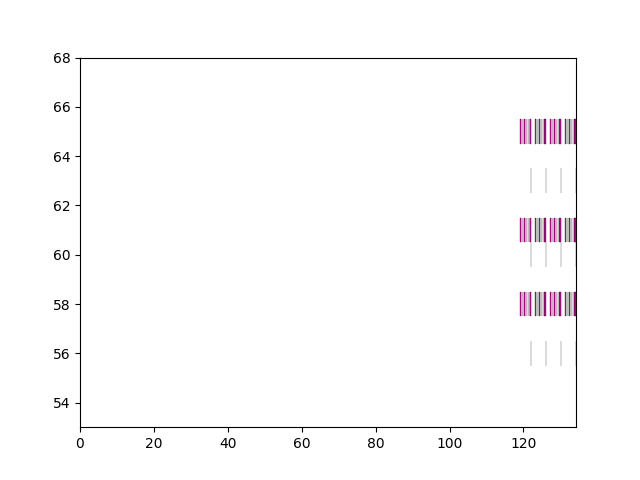

In [116]:
def plot_music(scheduled_style_df: pd.DataFrame, chroma_plot=False, ax=None, cmap=plt.get_cmap("gist_rainbow")):
    if ax is None:
        _, ax = plt.subplots()
    
    df_copy = scheduled_style_df[["time", "note", "time_duration", "time_release"]]
    if chroma_plot:
        df_copy.loc[:, "note"] = mu.to_chroma(df_copy["note"])
    for i, x in df_copy.iterrows():
        rect = patches.Rectangle((x.time, x.note - 0.5), width=x.time_duration, height=1, linewidth=0.2, edgecolor=(0,0,0), facecolor=cmap(x.note))
        ax.add_patch(rect)
    plt.xlim(0, df_copy.time_release.max())
    plt.ylim(df_copy.note.min() - 3, df_copy.note.max() + 3)

plot_music(pd_track, chroma_plot=False)

In [103]:
midi_ids = pd_track.note.to_numpy()

# Transposition:
transposition = 0
midi_ids += (transposition%12)

# general_scale_subset = scales.create_general_scale_subset()
general_scale_subset = scales.create_general_scale_subset(note_counts=[5,7])

print(len(general_scale_subset), "general scales will be examined")
music_note_count = len(midi_ids)
print("Music note count:", music_note_count)
window_size = max(int(music_note_count * 0.1), 14)
print("Window size:", window_size)

print(scales.windowed_suggest_scales(midi_ids, threshold=0.9, window_size=window_size, window_threshold=0.9, general_scale_subset=general_scale_subset))

NameError: name 'scales' is not defined